# Problem Statement

Build an optimal model that can help us identify bot traffic coming  from search engines (NHT-search), other bot traffic (NHT-other) and human traffic (HT).

# 1)-Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

In [0]:
# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [0]:
# For processing and maths
import numpy as np
import pandas as pd
import re
import requests
import pickle

In [20]:
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
# For modeling building and tunning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
# for evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 2)-Loading data

In [23]:
df = pd.read_pickle('clickdata.pkl')
df.head()

,labels,visitor_recognition_type,country_by_ip_address,region_by_ip_address
0,NHT,ANONYMOUS,US,CA
1,NHT,ANONYMOUS,US,CA
2,HT,ANONYMOUS,IT,LI
3,NHT,ANONYMOUS,US,CA
4,NHT,ANONYMOUS,US,CA


In [24]:
df.shape

(59638, 4)

In [25]:
df.labels.value_counts()

HT     38497
NHT    21141
Name: labels, dtype: int64

In [26]:
n_group = df['labels'].value_counts()
n_group_sum = n_group.sum()

print('Human Traffic: {}'.format(n_group[0]))
print('Non-Human Traffic: {}'.format(n_group[1]))

print('percentage of Human Traffic: {:.2f} {}'.format(n_group[0]/n_group_sum*100, '%'))
print('percentage of Non-Human Traffic: {:.2f} {}'.format(n_group[1]/n_group_sum*100, '%'))

Human Traffic: 38497
Non-Human Traffic: 21141
percentage of Human Traffic: 64.55 %
percentage of Non-Human Traffic: 35.45 %


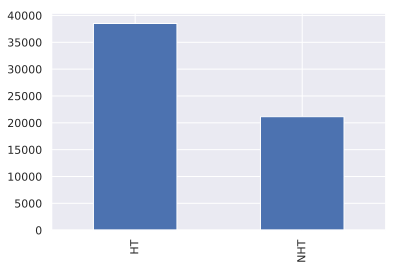

In [27]:
df['labels'].value_counts().plot.bar()

In [0]:
# Encoding target feature
df['labels'] = df.labels.map({'NHT':'0', 'HT':'1'})

In [0]:
df=df.sample(10000)

In [0]:
y=df.labels
X=df[['visitor_recognition_type','country_by_ip_address','region_by_ip_address']]

In [0]:
# convert other categorical features 

X = pd.get_dummies(data=df[['country_by_ip_address', 'region_by_ip_address', 'visitor_recognition_type']], drop_first=True)

In [32]:
print(y.shape)
print(X.shape)

(10000,)
(10000, 172)


### Train and Test split

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 172)
(2000, 172)
(8000,)
(2000,)


# 3)-Model Building

In [0]:
models = []
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier()))
models.append(("DT",DecisionTreeClassifier()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVM",SVC()))

In [36]:
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
for i in range(len(names)):
    print(names[i],results[i].mean())

NB 0.9710000000000001
KNN 0.977375
DT 0.9783749999999998
RF 0.9780000000000001
SVM 0.9732499999999998


Random Forest performs best on training data with 97.8 accuracy.

**How about test data?**

In [37]:
results = []
names = []
for name,model in models:
    kfold = KFold(n_splits=10, random_state=22)
    cv_result = cross_val_score(model,X_test,y_test, cv = kfold,scoring = "accuracy")
    names.append(name)
    results.append(cv_result)
for i in range(len(names)):
    print(names[i],results[i].mean())

NB 0.9695
KNN 0.9705
DT 0.9800000000000001
RF 0.9805000000000001
SVM 0.9765


[Text(0, 0, 'NB'),
 Text(0, 0, 'KNN'),
 Text(0, 0, 'DT'),
 Text(0, 0, 'RF'),
 Text(0, 0, 'SVM')]

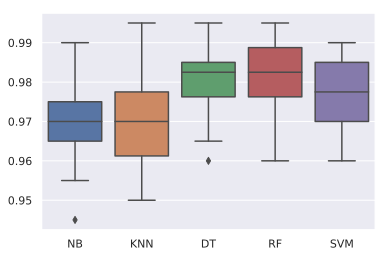

In [38]:
ax = sns.boxplot(data=results)
figsize=(16, 7)
ax.set_xticklabels(names)

### Model Tunning

Adding more estimators, and playing with parameters..........I came up with better accuracy

In [39]:
rf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
pred_rf[:5]

array(['0', '1', '1', '1', '1'], dtype=object)

In [40]:
print(accuracy_score(y_test, pred_rf))

0.9815


### confusion Matrix

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_rf)
cm

array([[ 748,    4],
       [  33, 1215]])

### Classification Report

In [42]:
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       752
           1       1.00      0.97      0.99      1248

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000

